## Accessing Landsat Collection 2 Level-1 and Level-2 data with the Planetary Computer STAC API

The Planetary Computer's [Landsat](https://landsat.gsfc.nasa.gov/) dataset represents a global archive of [Level-1](https://www.usgs.gov/landsat-missions/landsat-collection-2-level-1-data) and [Level-2](https://www.usgs.gov/landsat-missions/landsat-collection-2-level-2-science-products) data from from [Landsat Collection 2](https://www.usgs.gov/core-science-systems/nli/landsat/landsat-collection-2). The dataset is grouped into two STAC Collections:
- `landsat-c2-l2` for Level-2 data
- `landsat-c2-l1` for Level-1 data

This notebook demonstrates the use of the Planetary Computer STAC API to query for Landsat data. We will start with an example using Level-2 data and follow with a similar example using Level-1 data.

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. 
- The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.
- To use your API key locally, set the environment variable `PC_SDK_SUBSCRIPTION_KEY` or use `pc.settings.set_subscription_key(<YOUR API Key>)`.

In [1]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc
from odc.stac import stac_load
import matplotlib.pyplot as plt

### Choose an area and time of interest

This area is in Redmond, WA, USA, near Microsoft's main campus. We'll search all of 2021. 

In [2]:
bbox_of_interest = [-122.2751, 47.5469, -121.9613, 47.7458]
time_of_interest = "2021-01-01/2021-12-31"

### Search the collection and choose a scene to render

Use [pystac-client](https://github.com/stac-utils/pystac-client) to perform the search over the Landsat Collection 2 Level-2 collection (`landsat-c2-l2`), specifying we want results with less than 10% cloud cover.

In [3]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

items = list(search.get_items())
print(f"Returned {len(items)} Items")

Returned 13 Items


Let's find the least cloudy of the bunch.

In [4]:
selected_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
    + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
)

Choosing LC08_L2SP_046027_20210725_02_T1 from 2021-07-25 with 0.38% cloud cover


### Available assets

In additon to numerous metadata assets, each Electro-Optical (EO) band is a separate asset.

In [5]:
max_key_length = len(max(selected_item.assets, key=len))
for key, asset in selected_item.assets.items():
    print(f"{key.rjust(max_key_length)}: {asset.title}")

              qa: Surface Temperature Quality Assessment Band
             ang: Angle Coefficients File
             red: Red Band
            blue: Blue Band
            drad: Downwelled Radiance Band
            emis: Emissivity Band
            emsd: Emissivity Standard Deviation Band
            trad: Thermal Radiance Band
            urad: Upwelled Radiance Band
           atran: Atmospheric Transmittance Band
           cdist: Cloud Distance Band
           green: Green Band
           nir08: Near Infrared Band 0.8
          lwir11: Surface Temperature Band
          swir16: Short-wave Infrared Band 1.6
          swir22: Short-wave Infrared Band 2.2
         coastal: Coastal/Aerosol Band
         mtl.txt: Product Metadata File (txt)
         mtl.xml: Product Metadata File (xml)
        mtl.json: Product Metadata File (json)
        qa_pixel: Pixel Quality Assessment Band
       qa_radsat: Radiometric Saturation and Terrain Occlusion Quality Assessment Band
      qa_aerosol: Aeros

### Render a natural color image of the AOI

We'll start by loading the red, green, and blue bands for our area of interest into an xarray dataset using [`odc-stac`](https://pypi.org/project/odc-stac/). We will also load the nir08 band for use in computing an NDVI value in a later example. Note that we pass the `sign` function from the [planetary-computer](https://github.com/microsoft/planetary-computer-sdk-for-python) package so that `odc-stac` can supply the required [Shared Access Signature](https://docs.microsoft.com/en-us/azure/storage/common/storage-sas-overview) tokens that are necessary to download the asset data.

In [6]:
bands_of_interest = ["nir08", "red", "green", "blue"]
data = stac_load(
    [selected_item], bands=bands_of_interest, patch_url=pc.sign, bbox=bbox_of_interest
).isel(time=0)
data

<xarray.Dataset>
Dimensions:      (y: 747, x: 795)
Coordinates:
    time         datetime64[ns] 2021-07-25T18:55:39.475647
  * y            (y) float64 5.289e+06 5.289e+06 ... 5.266e+06 5.266e+06
  * x            (x) float64 5.543e+05 5.544e+05 ... 5.781e+05 5.781e+05
    spatial_ref  int32 32610
Data variables:
    nir08        (y, x) uint16 7182 7216 7248 7288 ... 18508 16865 18852 25114
    red          (y, x) uint16 7152 7192 7226 7269 7294 ... 8128 8774 8552 7981
    green        (y, x) uint16 7483 7523 7560 7597 7596 ... 8673 8987 8925 8693
    blue         (y, x) uint16 7329 7397 7465 7535 7525 ... 8091 8655 8274 7965
Attributes:
    crs:           EPSG:32610
    grid_mapping:  spatial_ref

Now we'll convert our xarray Dataset to a DataArray and plot the RGB image. We set `robust=True` in `imshow` to avoid manual computation of the color limits (vmin and vmax) that is necessary for data not scaled to between 0-1 while also eliminating extreme values that can cause a washed out image.

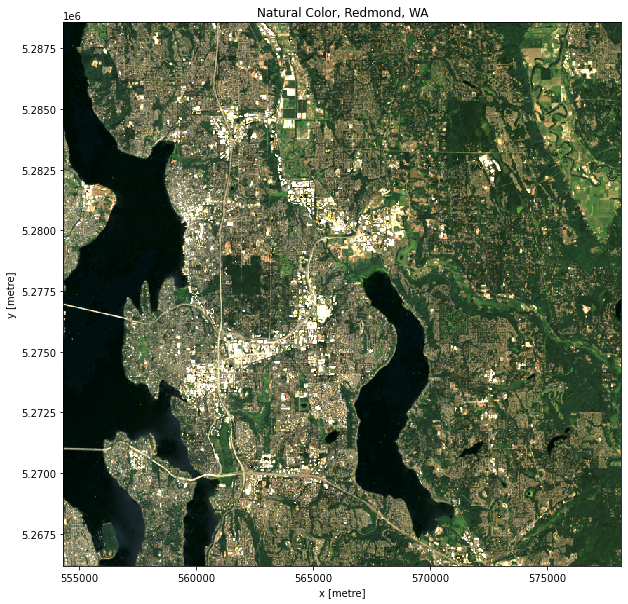

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))

data.drop_vars("nir08").to_array().plot.imshow(robust=True, ax=ax)
ax.set_title("Natural Color, Redmond, WA");

### Render an NDVI image of the AOI

Landsat has several bands, and with them we can go beyond rendering natural color imagery; for example, the following code computes a [Normalized Difference Vegetation Index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) using the near-infrared and red bands. Note that we convert the red and near infrared bands to a data type that can contain negative values; if this is not done, negative NDVI values will be incorrectly stored.

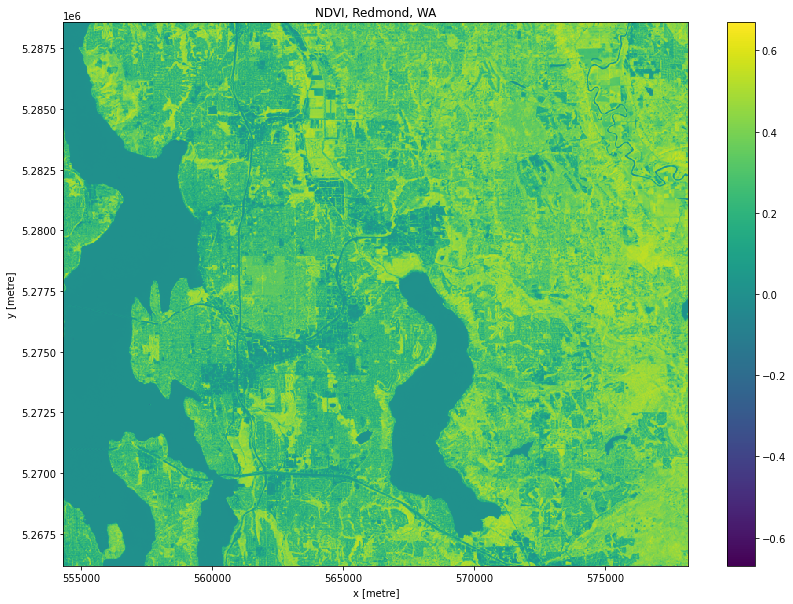

In [8]:
red = data["red"].astype("float")
nir = data["nir08"].astype("float")
ndvi = (nir - red) / (nir + red)

fig, ax = plt.subplots(figsize=(14, 10))
ndvi.plot.imshow(ax=ax, cmap="viridis")
ax.set_title("NDVI, Redmond, WA");

### Selecting specific platforms

Landsat Collection 2 Level-2 includes assets from several different Platforms.

In [9]:
catalog.get_collection("landsat-c2-l2").summaries.to_dict()["platform"]

['landsat-4', 'landsat-5', 'landsat-7', 'landsat-8', 'landsat-9']

You might want to limit your search to a specific platform or platforms, to avoid the [Landsat 7 Scan Line Corrector failure](https://www.usgs.gov/landsat-missions/landsat-7), for example. Use the `"platform": {"in": ... }` query to select specific platforms.

In [10]:
search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox_of_interest,
    datetime=time_of_interest,
    query={
        "eo:cloud_cover": {"lt": 10},
        "platform": {"in": ["landsat-8", "landsat-9"]},
    },
)
items = search.get_all_items()

### Landsat Collection 2 Level-1 Data

Thus far we have worked with Landsat Collection 2 Level-2 data, which is processed to a consistent set of surface reflectance and surface temperature [science products](https://www.usgs.gov/landsat-missions/landsat-science-products). 

The Planetary Computer also hosts Collection 2 Level-1 data (top of atmosphere values) acquired by the [Multispectral Scanner System](https://landsat.gsfc.nasa.gov/multispectral-scanner-system/) (MSS) onboard Landsat 1 through 5. These data do not include a blue band, so a natural color image is not possible. We will plot a color infrared image from the nir08, red, and green bands instead.

As before, we use pystac-client to search over the `landsat-c2-l1` collection. We'll use the same area of interest and return only those with less than 10% cloud cover.

In [11]:
search = catalog.search(
    collections=["landsat-c2-l1"],
    bbox=bbox_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

items = list(search.get_items())
print(f"Returned {len(items)} Items")

Returned 272 Items


Choose the least cloudy Item.

In [12]:
selected_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
    + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
)

Choosing LM05_L1TP_046027_20121004_02_T2 from 2012-10-04 with 0.0% cloud cover


### Available assets

MSS data has four EO bands assets and a number of metadata files and bands.

In [13]:
max_key_length = len(max(selected_item.assets, key=len))
for key, asset in selected_item.assets.items():
    print(f"{key.rjust(max_key_length)}: {asset.title}")

             red: Red Band
           green: Green Band
           nir08: Near Infrared Band 0.8
           nir09: Near Infrared Band 0.9
         mtl.txt: Product Metadata File (txt)
         mtl.xml: Product Metadata File (xml)
        mtl.json: Product Metadata File (json)
        qa_pixel: Pixel Quality Assessment Band
       qa_radsat: Radiometric Saturation and Dropped Pixel Quality Assessment Band
        tilejson: TileJSON with default rendering
rendered_preview: Rendered preview


We'll use `odc-stac` to load only the EO bands and area we are interested in.

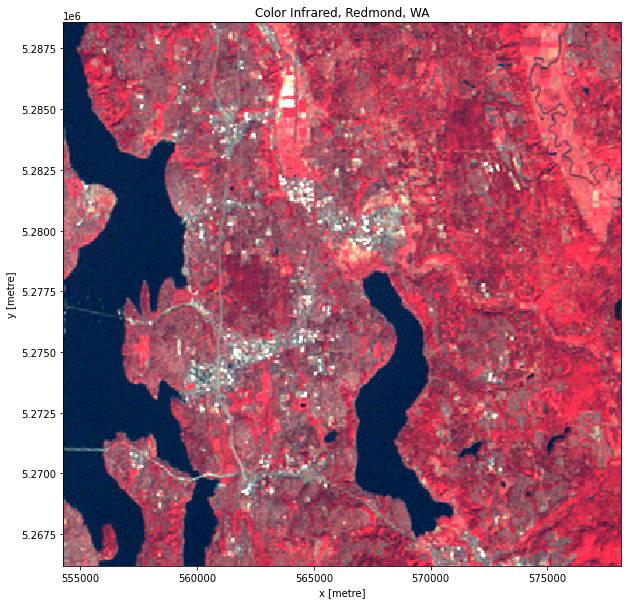

In [14]:
bands_of_interest = ["nir08", "red", "green"]
data = stac_load(
    [selected_item], bands=bands_of_interest, patch_url=pc.sign, bbox=bbox_of_interest
).isel(time=0)

cir = data.to_array()

fig, ax = plt.subplots(figsize=(10, 10))
cir.plot.imshow(robust=True, ax=ax)
ax.set_title("Color Infrared, Redmond, WA");